In [2]:
import numpy as np
import scipy.stats as st
import statsmodels.datasets as ds
import matplotlib.pyplot as plt
%matplotlib inline

心臓移植後の生存期間データを使う

In [3]:
data = ds.heart.load_pandas().data

In [4]:
data.tail()

,survival,censors,age
64,14.0,1.0,40.3
65,167.0,0.0,26.7
66,110.0,0.0,23.7
67,13.0,0.0,28.9
68,1.0,0.0,35.2


censor列の値0は、調査終了の時点で患者が生存していた＝正確な生存期間がわからないことを意味する。
以下、観察打ち切りをしていないデータを使う（その結果、移植手術後にあまり長く生存できなかった患者に対するデータを主に扱う）

In [5]:
data = data[data.censors==1]
survival = data.survival

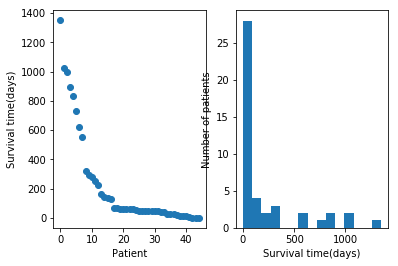

In [6]:
plt.subplot(121)
plt.plot(sorted(survival)[::-1], 'o')
plt.xlabel('Patient')
plt.ylabel('Survival time(days)')
plt.subplot(122)
plt.hist(survival, bins=15)
plt.xlabel('Survival time(days)')
plt.ylabel('Number of patients')

このデータに指数分布を当てはめてみる。

指数分布の確率密度関数は、P(X | λ)=λ*exp(-λ*X) (X >= 0) で与えられる。
最も当てはまりのよい指数分布をみつけるために、パラメータλに対する最尤推定を行う。
最尤関数L(λ, {s[i]})=P({s[i]} | λ)=λ**n * exp(-λ * n * smean) は、λ=1/smeanのとき最大値を取る。

In [7]:
smean = survival.mean()
rate = 1./smean

In [8]:
smax = survival.max()
days = np.linspace(0., smax, 1000)
dt = smax / 999.
dist_exp = st.expon.pdf(days, scale=1./rate)

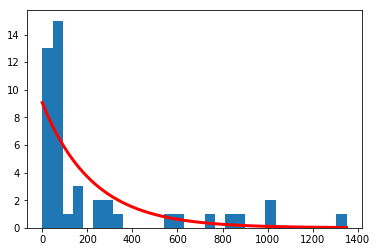

In [9]:
nbins = 30
plt.hist(survival, nbins)
plt.plot(days, dist_exp*len(survival)*smax/nbins, '-r', lw=3)

見た感じ、指数分布は当てはまりがよいとは言えない。

In [10]:
dist = st.expon
args = dist.fit(survival); args

(0.99999999994836486, 222.28880590143666)

コルモゴロフ・スミルノフ検定（経験分布と対象分布の累計分布関数との比較をおこなう）



In [12]:
st.kstest(survival, dist.cdf, args)

KstestResult(statistic=0.36199685486406347, pvalue=8.6470960143358866e-06)

2つ目の値＝p値が非常に小さいので、帰無仮説（＝観測されたデータは最尤パラメータrateの指数分布に起因する）は、高信頼度で棄却できる。
そこで、その他の分布、例えば故障が発生するまでの時間をモデル化するときなどによく使われるバーンダウム・サンダース分布で調べてみる。

In [14]:
dist2 = st.fatiguelife
args2 = dist2.fit(survival)
st.kstest(survival, dist2.cdf, args2)

KstestResult(statistic=0.18773446101946889, pvalue=0.073211497000863268)

p値が0.07なので、5％の信頼度で帰無仮説を棄却できない。
結果をグラフで示すと、指数分布よりもよく適合していることがわかる。

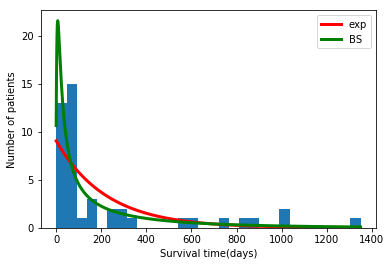

In [15]:
dist_fl = dist2.pdf(days, *args2)
nbins = 30
plt.hist(survival, nbins)
plt.plot(days, dist_exp*len(survival)*smax/nbins, '-r', lw=3, label='exp')
plt.plot(days, dist_fl*len(survival)*smax/nbins, '-g', lw=3, label='BS')
plt.xlabel("Survival time(days)")
plt.ylabel("Number of patients")
plt.legend()